In [ ]:
import copy

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt


if torch.backends.mps.is_available():
    device = torch.device("mps")   # GPU на Mac (Apple Silicon або AMD)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU (не на Mac)
    print(f"GPU count: {torch.cuda.device_count()}"
          f", CUDA version: {torch.version.cuda}"
          f", cuDNN version: {torch.backends.cudnn.version()}")
else:
    device = torch.device("cpu")   # fallback

print("Using GPU:", device)

GPU count: 1, CUDA version: 12.8, cuDNN version: 91002
Using GPU: cuda


## Hyperparameters

In [ ]:
batch_size=32
num_epochs = 20
features = 100

patience = 5
counter = 0

lr=1e-3
weight_decay=1e-4

PATH='./CIFAR100_ResNET.pth'

num_workers = 8 if device.type == "cuda" else 0

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(32, padding=4),
                                transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transform_test = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_dataset = torchvision.datasets.CIFAR100(root='./cifar100',
                                           download=True,
                                           transform=transform,
                                           train=True)

test_dataset = torchvision.datasets.CIFAR100(root='./cifar100',
                                             download=True,
                                             transform=transform_test,
                                             train=False)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          num_workers=num_workers,
                                          shuffle=True)

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, features) # fc - fully connected layer (last layer)
model = model.to(device)

for params in model.parameters():
    params.requires_grad = False
model.fc = model.fc.requires_grad_(True)

In [22]:
def run_one_epoch(model_f, train_loader_f, device_f, criterion_f, optimizer_f):
    """
    Run one epoch of training
    
    Args:
        model_f: the model to train
        train_loader_f: DataLoader for training data
        device_f: device to run the training on (CPU or GPU)
        criterion_f: loss function
        optimizer_f: optimizer for updating model parameters
    Returns:
        Tuple of (average loss, accuracy) for the epoch
    """

    model_f.train()
    running_loss, correct = 0.0, 0
    for images_f, labels_f in train_loader_f:
        # Load to GPU/NPU/CPU
        images_f, labels_f = images_f.to(device_f), labels_f.to(device_f)

        outputs_f = model_f(images_f)

        l = criterion_f(outputs_f, labels_f)
        l.backward()

        optimizer_f.step()
        optimizer_f.zero_grad()
        running_loss += l.item()

        # Calculate accuracy of model outputs
        correct += (outputs_f.argmax(1) == labels_f).sum().item()

    return (
        running_loss / len(train_loader_f),     # average loss
        correct / len(train_loader_f.dataset))  # accuracy

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

best_train_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

train_losses, train_accs = [], []

for epoch in range(num_epochs):
    training_loss, training_accuracy = run_one_epoch(
        model, train_loader, 
        device, criterion, optimizer)

    train_losses.append(training_loss)
    train_accs.append(training_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {training_loss:.4f}, "
          f"Train Acc: {training_accuracy:.4f} ")

    if training_loss < best_train_loss:
        best_train_loss = training_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter > patience:
            print('Early stop triggered')
            break

Epoch [1/20] Train Loss: 4.1237, Train Acc: 0.1238 
Epoch [2/20] Train Loss: 3.8758, Train Acc: 0.1643 
Epoch [3/20] Train Loss: 3.8239, Train Acc: 0.1727 
Epoch [4/20] Train Loss: 3.8137, Train Acc: 0.1792 
Epoch [5/20] Train Loss: 3.7926, Train Acc: 0.1792 
Epoch [6/20] Train Loss: 3.7989, Train Acc: 0.1807 
Epoch [7/20] Train Loss: 3.7716, Train Acc: 0.1824 
Epoch [8/20] Train Loss: 3.7755, Train Acc: 0.1853 
Epoch [9/20] Train Loss: 3.7904, Train Acc: 0.1823 
Epoch [10/20] Train Loss: 3.7919, Train Acc: 0.1875 
Epoch [11/20] Train Loss: 3.7890, Train Acc: 0.1837 
Epoch [12/20] Train Loss: 3.7816, Train Acc: 0.1847 
Epoch [13/20] Train Loss: 3.8088, Train Acc: 0.1817 
Early stop triggered


In [24]:
model.load_state_dict(best_model_wts)

for params in model.parameters():
    params.requires_grad = True

fine_tune_epoch = 10
for epoch in range(fine_tune_epoch):
    training_loss, training_accuracy = run_one_epoch(
        model, train_loader, device, 
        criterion, optimizer)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {training_loss:.4f}, "
          f"Train Acc: {training_accuracy:.4f} ")

torch.save(model.state_dict(), PATH)
print('Training finished')

Epoch [1/20] Train Loss: 3.2890, Train Acc: 0.2190 
Epoch [2/20] Train Loss: 2.6757, Train Acc: 0.3274 
Epoch [3/20] Train Loss: 2.4806, Train Acc: 0.3660 
Epoch [4/20] Train Loss: 2.3449, Train Acc: 0.3903 
Epoch [5/20] Train Loss: 2.2276, Train Acc: 0.4153 
Epoch [6/20] Train Loss: 2.1432, Train Acc: 0.4340 
Epoch [7/20] Train Loss: 2.0457, Train Acc: 0.4558 
Epoch [8/20] Train Loss: 1.9727, Train Acc: 0.4699 
Epoch [9/20] Train Loss: 1.9181, Train Acc: 0.4850 
Epoch [10/20] Train Loss: 1.8649, Train Acc: 0.4979 
Training finished


In [ ]:
load_model = models.resnet50()
load_model.fc = nn.Linear(load_model.fc.in_features, features)
load_model.load_state_dict(torch.load(PATH))
load_model.eval()

with torch.no_grad():
    n_correct = 0
    n_samples = len(test_loader.dataset)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

    acc = n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} test image: {100*acc}%')

Accuracy of the network on the 10000 test image: 49.09%


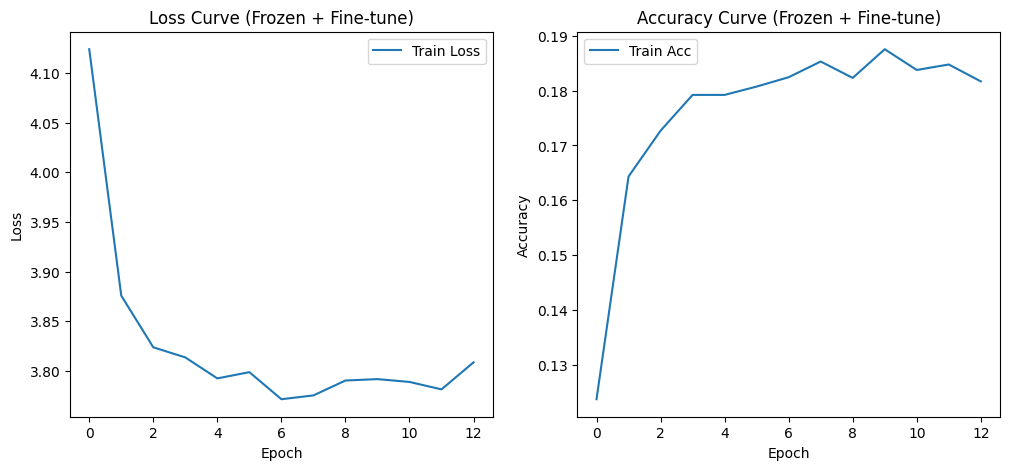

In [27]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve (Frozen + Fine-tune)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve (Frozen + Fine-tune)')
plt.legend()

plt.show()